# Implement NN model for animal faces classification

This notebook uses the AFHQ dataset for testing a fully-connected NN and simple CNN for image classification. Not sure why, but I really like this dataset over some others. Not for any reason other than the way it looks. 

In [24]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

from tqdm.notebook import tqdm, trange

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 4)

## Download data

In [4]:
!sh ./utils/get_animaldata32x32.sh

Current working directory: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning
Data already downloaded.
MNIST      afhq       afhq_32x32
Cloning into 'AnimalFaces32x32'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
Archive:  /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data/AnimalFaces32x32/afhq_32x32.zip
   creating: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data/AnimalFaces32x32/afhq/train/
   creating: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data/AnimalFaces32x32/afhq/train/cat/
  inflating: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data/AnimalFaces32x32/afhq/train/cat/flickr_cat_000002.jpg  
  inflating: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data/AnimalFaces32x32/afhq/train/cat/flickr_cat_000003.jpg  
  inflating: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning/data

In [23]:
# %%bash
# PROJECT_DIR=$(pwd) && echo "Current working directory: ${PROJECT_DIR}"
# if [ -d "${PROJECT_DIR}/data/AnimalFaces32x32" ]; then
#     echo "Data already downloaded."
# else
#     echo "Downloading data..."
# fi
# cd ${PROJECT_DIR}/data/ && ls
# git clone https://github.com/arashash/AnimalFaces32x32
# unzip ${PROJECT_DIR}/data/AnimalFaces32x32/afhq_32x32.zip -d ${PROJECT_DIR}/data/AnimalFaces32x32/
# mv ${PROJECT_DIR}/data/AnimalFaces32x32/afhq ${PROJECT_DIR}/data/afhq_32x32
# rm -r AnimalFaces32x32/
# cd ${PROJECT_DIR}

Current working directory: /Users/justinbrantley/Dropbox/KLAB/Deep-Learning
MNIST
afhq


Cloning into 'AnimalFaces32x32'...


In [75]:
# ! [ ! -d "./data/AnimalFaces32x32x" ]
# !rm -r AnimalFaces32x32/
# !git clone https://github.com/arashash/AnimalFaces32x32
# !rm -r afhq/
# !unzip ./AnimalFaces32x32/afhq_32x32.zip -d ./AnimalFaces32x32
# !mv ./AnimalFaces32x32/afhq ./afhq_32x32

Directory exists.


# Load data

In [61]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set Batch size for dataloaders
BATCH_SIZE = 64

# Set data directory
data_dir = './data/afhq_32x32/'
train_images     = ImageFolder(data_dir + "train/", transform=transforms.ToTensor())
validate_dataset = ImageFolder(data_dir + "val/" , transform=transforms.ToTensor())

# Number of classes
num_classes = len(os.listdir(data_dir + "train/"))

# Split train data into train/test
size_test = round(0.2*len(train_images))
train_dataset, test_dataset = random_split(train_images,[len(train_images)-size_test, size_test])

# Create data loader for training and validation
train_loader    = DataLoader(train_dataset,    BATCH_SIZE, shuffle=True)
validate_loader = DataLoader(validate_dataset, BATCH_SIZE, shuffle=False)
test_loader     = DataLoader(test_dataset,     BATCH_SIZE, shuffle=False)

### Visualize a batch of images

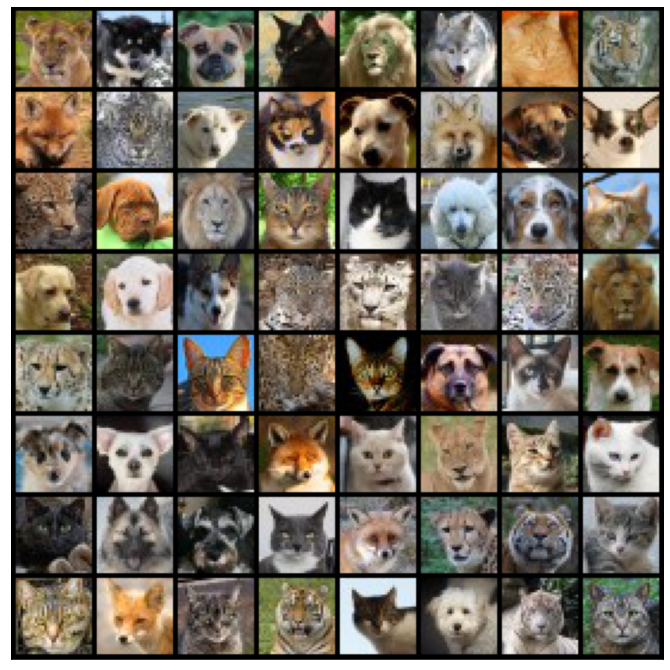

In [34]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    ax.set_xticks([]); ax.set_yticks([])
    break

# Write train/test functions 
(would be nice to rewrite these as methods for a class that inherets from `nn.module`)

In [51]:
# Training function
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
    # Initialize
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    # Loop through each epoch
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 

        # Train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                # Move to device
                data, target = data.to(device), target.to(device)

                # Zero the gradients out
                optimizer.zero_grad()

                # Get the model output
                output = model(data)

                # Compute Loss
                loss = criterion(output,target)

                # Calculate the gradients
                loss.backward() 

                # Update the weights
                optimizer.step()
                
                # Set the loss
                tepoch.set_postfix(loss=loss.item())
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append the loss
        train_loss.append(loss.item()) 
        train_acc.append(correct/total)
    
        # Evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append validation loss
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    return train_loss, train_acc, validation_loss, validation_acc 

def test(model, device, data_loader,num_classes):
    model.eval()
    correct,total = 0, 0
    confusion_matrix = torch.zeros(num_classes,num_classes)

    for (inputs,labels) in data_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    # Compute accuracy
    acc = 100 * correct / total
    
    return acc, confusion_matrix

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


In [54]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 3, 32, 32])

# Feed forward NN

In [66]:
# Just linear layers with relu activation
class FFN(nn.Module):
  def __init__(self,input_size=3*512*512,num_classes=3):       
    super(FFN, self).__init__()
    self.fc1 = nn.Linear(input_size, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

# Add batch norm and dropout
class FFN_BN(nn.Module):
  def __init__(self,input_size=3*512*512,num_classes=3):       
    super(FFN_BN, self).__init__()
    # Linear layers
    self.fc1 = nn.Linear(input_size, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, num_classes)

    # Add batch norm
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(64)
    self.bn3 = nn.BatchNorm1d(32)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    output = F.log_softmax(x, dim=1)
    return output

In [52]:
net = FFN(input_size=np.prod(example_data.shape[1:])).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=1e-4,weight_decay=0.0001)
num_epochs = 15
train_loss, train_acc, validation_loss, validation_acc = train(net, dev, train_loader, validate_loader, num_epochs, criterion, optimizer)

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

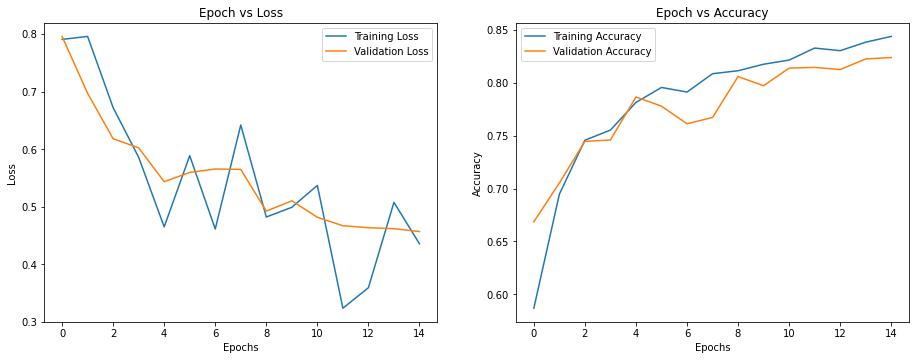

In [53]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [64]:
test(net,dev, test_loader,num_classes=num_classes)

(85.09911141490089,
 tensor([[884.,  71.,  60.],
         [ 68., 818.,  65.],
         [ 84.,  88., 788.]]))

# Add batch normalization and dropout

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

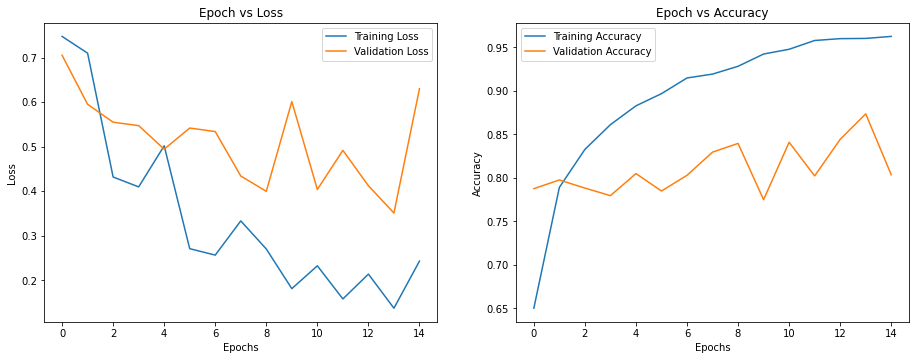

In [67]:
net_bn = FFN_BN(input_size=np.prod(example_data.shape[1:])).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_bn.parameters(),lr=1e-4,weight_decay=0.0001)
num_epochs = 15
train_loss, train_acc, validation_loss, validation_acc = train(net_bn, dev, train_loader, validate_loader, num_epochs, criterion, optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [68]:
test(net_bn,dev, test_loader,num_classes=num_classes)

(79.08407382091593,
 tensor([[607.,  83., 325.],
         [ 13., 791., 147.],
         [  5.,  39., 916.]]))